### https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/agent/4.policy-gradient-agent.ipynb

In [1]:
import numpy as np
import pandas as pd
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [10]:
tf.disable_v2_behavior()

In [2]:
%matplotlib inline

In [3]:
from lutils.stock import LTdxHq

In [4]:
ltdxhq = LTdxHq()

In [5]:
code = '000001'

In [6]:
df = ltdxhq.get_k_data_daily(code, start='2001-01-01')

In [7]:
df

,open,close,high,low,volume,amount
date,,,,,,
2001-01-02,3.42,3.43,3.46,3.39,3412200.0,4.950500e+07
2001-01-03,3.43,3.40,3.44,3.38,5429400.0,7.830400e+07
2001-01-04,3.40,3.38,3.42,3.37,4840400.0,6.957300e+07
2001-01-05,3.38,3.34,3.38,3.33,6641900.0,9.415400e+07
2001-01-08,3.34,3.30,3.34,3.29,6994400.0,9.804400e+07
...,...,...,...,...,...,...
2023-06-02,11.68,11.93,11.97,11.64,122184256.0,1.446503e+09
2023-06-05,11.88,11.91,12.00,11.82,52184620.0,6.205314e+08
2023-06-06,11.91,11.84,12.09,11.82,83327344.0,9.970393e+08


In [8]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [11]:
close = df.close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

D:\Software\Python\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  app.launch_new_instance()
D:\Software\Python\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
D:\Software\Python\tensorflow\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


epoch: 10, total rewards: 104.220000.3, cost: -35230.730469, total money: 9914.800000
epoch: 20, total rewards: 232.920000.3, cost: -35382.628906, total money: 9770.180000
epoch: 30, total rewards: 253.030000.3, cost: -35434.691406, total money: 9661.560000
epoch: 40, total rewards: 285.160000.3, cost: -35259.011719, total money: 9563.900000
epoch: 50, total rewards: 90.970000.3, cost: -35011.796875, total money: 9216.820000
epoch: 60, total rewards: 227.520000.3, cost: -35338.453125, total money: 9604.450000
epoch: 70, total rewards: 221.030000.3, cost: -35073.875000, total money: 9315.730000
epoch: 80, total rewards: 214.960000.3, cost: -35168.726562, total money: 9337.420000
epoch: 90, total rewards: 196.390000.3, cost: -35093.050781, total money: 9211.670000
epoch: 100, total rewards: 233.050000.3, cost: -35178.187500, total money: 9168.150000
epoch: 110, total rewards: 271.130000.3, cost: -35197.726562, total money: 9176.810000
epoch: 120, total rewards: 279.440000.3, cost: -35198

In [12]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 3.430000, total balance 9996.570000
day 1: buy 1 unit at price 3.400000, total balance 9993.170000
day 2, sell 1 unit at price 3.380000, investment -1.457726 %, total balance 9996.550000,
day 3, sell 1 unit at price 3.340000, investment -1.764706 %, total balance 9999.890000,
day 4: buy 1 unit at price 3.300000, total balance 9996.590000
day 5: buy 1 unit at price 3.430000, total balance 9993.160000
day 8: buy 1 unit at price 3.490000, total balance 9989.670000
day 9: buy 1 unit at price 3.340000, total balance 9986.330000
day 12: buy 1 unit at price 3.510000, total balance 9982.820000
day 13, sell 1 unit at price 3.530000, investment 6.969697 %, total balance 9986.350000,
day 14, sell 1 unit at price 3.440000, investment 0.291545 %, total balance 9989.790000,
day 19: buy 1 unit at price 3.390000, total balance 9986.400000
day 21: buy 1 unit at price 3.350000, total balance 9983.050000
day 22: buy 1 unit at price 3.330000, total balance 9979.720000
day 24, se

day 1052: buy 1 unit at price 1.540000, total balance 9971.200000
day 1053: buy 1 unit at price 1.550000, total balance 9969.650000
day 1054: buy 1 unit at price 1.550000, total balance 9968.100000
day 1056, sell 1 unit at price 1.510000, investment 1.342282 %, total balance 9969.610000,
day 1057, sell 1 unit at price 1.520000, investment 5.555556 %, total balance 9971.130000,
day 1058: buy 1 unit at price 1.550000, total balance 9969.580000
day 1059: buy 1 unit at price 1.510000, total balance 9968.070000
day 1060, sell 1 unit at price 1.500000, investment -2.597403 %, total balance 9969.570000,
day 1062: buy 1 unit at price 1.400000, total balance 9968.170000
day 1064, sell 1 unit at price 1.390000, investment -10.322581 %, total balance 9969.560000,
day 1066, sell 1 unit at price 1.370000, investment -11.612903 %, total balance 9970.930000,
day 1068, sell 1 unit at price 1.330000, investment -14.193548 %, total balance 9972.260000,
day 1071, sell 1 unit at price 1.390000, investment

day 2039, sell 1 unit at price 7.190000, investment -3.099730 %, total balance 10087.510000,
day 2040: buy 1 unit at price 6.940000, total balance 10080.570000
day 2041, sell 1 unit at price 6.900000, investment -2.266289 %, total balance 10087.470000,
day 2043: buy 1 unit at price 7.090000, total balance 10080.380000
day 2044, sell 1 unit at price 7.800000, investment 8.938547 %, total balance 10088.180000,
day 2046, sell 1 unit at price 8.010000, investment 22.290076 %, total balance 10096.190000,
day 2047, sell 1 unit at price 7.900000, investment 21.538462 %, total balance 10104.090000,
day 2048: buy 1 unit at price 7.920000, total balance 10096.170000
day 2049, sell 1 unit at price 7.840000, investment 30.884808 %, total balance 10104.010000,
day 2050: buy 1 unit at price 8.140000, total balance 10095.870000
day 2051: buy 1 unit at price 8.070000, total balance 10087.800000
day 2052: buy 1 unit at price 7.940000, total balance 10079.860000
day 2054: buy 1 unit at price 8.270000, t

day 3138, sell 1 unit at price 6.530000, investment 6.178862 %, total balance 10057.290000,
day 3139, sell 1 unit at price 6.450000, investment 5.392157 %, total balance 10063.740000,
day 3140: buy 1 unit at price 6.460000, total balance 10057.280000
day 3141: buy 1 unit at price 6.370000, total balance 10050.910000
day 3143, sell 1 unit at price 6.390000, investment 4.754098 %, total balance 10057.300000,
day 3144, sell 1 unit at price 6.330000, investment 3.262643 %, total balance 10063.630000,
day 3145: buy 1 unit at price 6.400000, total balance 10057.230000
day 3146: buy 1 unit at price 6.430000, total balance 10050.800000
day 3147: buy 1 unit at price 6.520000, total balance 10044.280000
day 3148: buy 1 unit at price 6.550000, total balance 10037.730000
day 3149: buy 1 unit at price 6.580000, total balance 10031.150000
day 3150: buy 1 unit at price 6.600000, total balance 10024.550000
day 3151, sell 1 unit at price 6.530000, investment 6.525285 %, total balance 10031.080000,
day 

day 4144: buy 1 unit at price 10.010000, total balance 9839.210000
day 4145, sell 1 unit at price 9.910000, investment -4.527938 %, total balance 9849.120000,
day 4146: buy 1 unit at price 9.350000, total balance 9839.770000
day 4149, sell 1 unit at price 9.830000, investment -3.343166 %, total balance 9849.600000,
day 4150, sell 1 unit at price 9.790000, investment -4.301075 %, total balance 9859.390000,
day 4151, sell 1 unit at price 9.570000, investment 1.700319 %, total balance 9868.960000,
day 4152, sell 1 unit at price 10.200000, investment 7.368421 %, total balance 9879.160000,
day 4154, sell 1 unit at price 10.280000, investment 8.668076 %, total balance 9889.440000,
day 4156: buy 1 unit at price 10.700000, total balance 9878.740000
day 4157: buy 1 unit at price 10.600000, total balance 9868.140000
day 4158, sell 1 unit at price 10.190000, investment 5.268595 %, total balance 9878.330000,
day 4159: buy 1 unit at price 10.330000, total balance 9868.000000
day 4160, sell 1 unit a

day 5181, sell 1 unit at price 14.670000, investment -7.793840 %, total balance 9395.600000,
day 5182, sell 1 unit at price 14.670000, investment -5.171299 %, total balance 9410.270000,
day 5185: buy 1 unit at price 14.970000, total balance 9395.300000
day 5187, sell 1 unit at price 15.090000, investment -2.076574 %, total balance 9410.390000,
day 5189: buy 1 unit at price 15.150000, total balance 9395.240000
day 5192: buy 1 unit at price 14.600000, total balance 9380.640000
day 5193, sell 1 unit at price 14.320000, investment -4.913679 %, total balance 9394.960000,
day 5194, sell 1 unit at price 14.000000, investment 2.941176 %, total balance 9408.960000,
day 5200, sell 1 unit at price 13.960000, investment -2.445842 %, total balance 9422.920000,
day 5203: buy 1 unit at price 13.430000, total balance 9409.490000
day 5204: buy 1 unit at price 14.150000, total balance 9395.340000
day 5207: buy 1 unit at price 14.050000, total balance 9381.290000
day 5208: buy 1 unit at price 13.860000, 

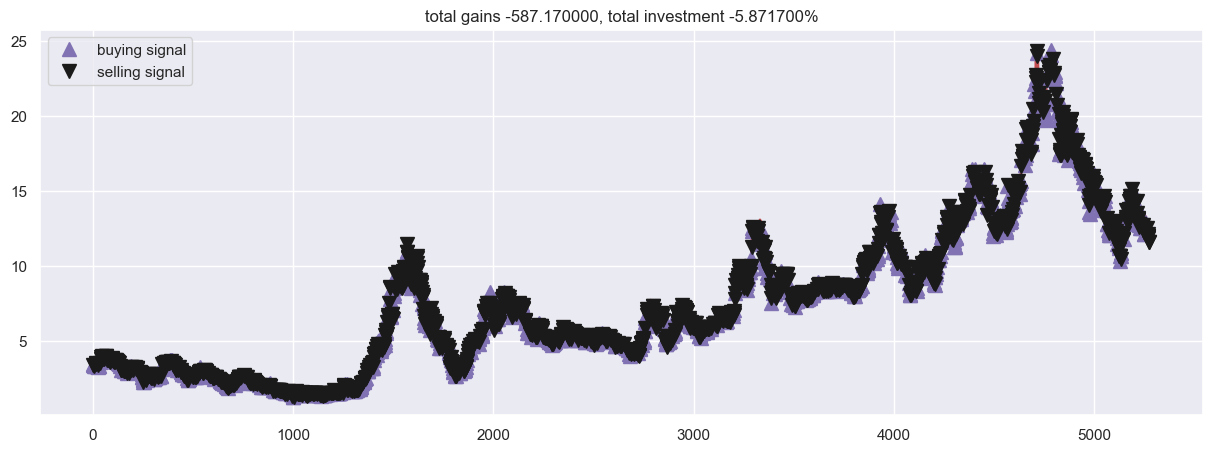

In [13]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()